# 1. Import Library

In [114]:
# basic library
import numpy as np
import pandas as pd
import datetime as dt
from math import sqrt
from datetime import timedelta

# plotting library
import plotly.express as px
import matplotlib.pyplot as plt


# modelling library
import xgboost as xgb
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit #splitting data
from sklearn.model_selection import RandomizedSearchCV #find the best parameter for model

# pipeline library
from sklearn.pipeline import Pipeline # the pipeline
from sklearn.compose import ColumnTransformer # pipeline that compiles the dataframe change process
from jcopml.pipeline import num_pipe, cat_pipe # to separate numerical and categorical categories

from jcopml.plot import plot_missing_value # not used because the data is clean
from jcopml.utils import save_model, load_model # save and load model
from feature_engine.outliers import Winsorizer # to cut the outliers
from jcopml.tuning.space import Integer, Real #to create a data range


# metric pipeline
from sklearn.metrics import mean_squared_error # combined with sqrt(square root) to get RMSE
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease # to find feature importance


# show 100 column
pd.options.display.max_columns = 100

# this library for avoid warnings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('mode.chained_assignment', None)

# this function for round 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 2. Import Dataset

In [115]:
data = pd.read_excel("GFP dataset.xlsx", index_col= 'Row_ID', date_parser='Order_Date')
df = data.copy()
df = df.drop(columns=['Order_ID', 'Order_month', 'Order_day', 'Order_Year', 
                      'Ship_Date', 'Lead_Time', 'Ship_Mode', 'Customer_ID', 
                      'Customer_Name', 'Segment', 'Country', 'City', 'State', 
                      'Postal_Code', 'Region', 'Product ID', 'Product Name', 
                      'Sales', 'Profit per item', 'Harga Per Item', 
                      'Total Cost per item', 'Harga Diskon per item', 
                      'Harga Jual per item', 'HPP per item',
                      'Cost', 'Cost Disc'
       ])

`This original dataset has been modified and some new columns have been added to improve the analysis, although no new columns were used in the regression process.`

# 3. Select Category and Sub-Category

In [116]:
def category_selection(cat, subcat, n_lag):
    df_x = df[(df['Category'] == cat) & (df['Sub-Category'] == subcat)]
    df_x = df_x.drop(columns= ['Category', 'Sub-Category'])
    df_x = df_x.groupby(['Order_Date']).mean()
    
    print('this is the PACF to determine the number of lags to use')
    sm.graphics.tsa.plot_pacf(df_x['Profit'], lags = n_lag, zero = False)
    plt.show()
    
    return df_x

this is the PACF to determine the number of lags to use


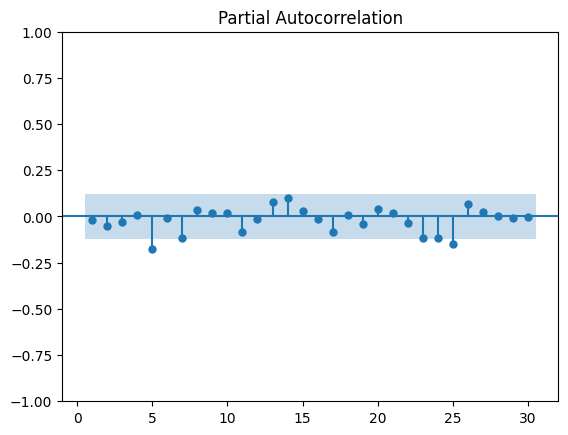

In [117]:
df_x = category_selection('Furniture', 'Tables', 30)

In [118]:
import seaborn as sns

# 4. Data Preprocessing & Modelling

In [119]:
# create a function and specify the some variables
def profit_pred_multiple(n_lags, n_gap, sales, cost, quantity, discount):
    
    # split the data set into X and y
    tss = TimeSeriesSplit(n_splits=5, test_size=30*1*1, gap= n_gap)
    df_xgb = df_x.sort_index()



    # create lags based on plot_pacf
    lags = n_lags

    def shift_lags(lags, df):
        for i in lags:
            df[f'lag{i}_profit'] = df['Profit'].shift(i)

    shift_lags(lags, df_xgb)
       
    
        
    # create pipeline   
    ## transform dataframe using scaling function
    preprocessor = ColumnTransformer([
        ('numeric', num_pipe(scaling = 'standard'), df_xgb.drop(columns = 'Profit').columns)
    ])

    ## processing the outliers data
    winsoriser = Winsorizer(capping_method='iqr', 
                            tail='both', 
                            fold=1.5,
                            variables=['Sales per Order', 'Quantity', 'Discount', 'Cost Gen'])

    # compile all processes in pipeline
    pipeline = Pipeline([
        ('outlier', winsoriser),
        ('prep', preprocessor)
    ])

    # this paramameter will used in RandomizedSearchCV
    parameter = {
        'base_score': np.linspace(0.5, 0.8, 4),
        'max_depth': np.arange(1, 10, 1),
        'learning_rate': np.linspace(0.05, 1, 100),
        'n_estimators': np.arange(100, 2000, 100),
        'subsample': Real(low=0.3, high=0.8, prior='uniform'),
        'gamma': Integer(low=1, high=10),
        'colsample_bytree': Real(low=0.1, high=2, prior='uniform'),
        'reg_alpha': Real(low=-3, high=3, prior='log-uniform'),
        'reg_lambda': Real(low=-3, high=3, prior='log-uniform'),
        'early_stopping_rounds' : [25, 50, 75],
    }
    
        
    # empty list
    fold = 0
    preds = []
    scores = []

    # split X, y data to Train and test
    for train_idx, val_idx in tss.split(df_xgb):
        train = df_xgb.iloc[train_idx]
        test = df_xgb.iloc[val_idx]
        
        X_train1 = train.drop(columns = 'Profit')
        y_train1 = train['Profit']
        
        X_test1 = test.drop(columns = 'Profit')
        y_test1 = test['Profit']
                
    # applying the pipeline (scaling and outliers processing) into X_train and X_test
        X_train = pd.DataFrame(pipeline.fit_transform(X_train1))
        X_test  = pd.DataFrame(pipeline.transform(X_test1))

    # rename each columns from X_train and X_test
        X_train = X_train.set_axis(list(X_train1.columns), axis=1)
        X_test  = X_test.set_axis(list(X_test1.columns), axis=1)

    
    # create the model
        reg = xgb.XGBRegressor(booster= 'gbtree', n_jobs=-1, random_state=41)                
        model = RandomizedSearchCV(reg, parameter, cv=5, n_iter=100, n_jobs=-1, verbose=0, random_state=41)
            
    # fit the model into data
        model.fit(X_train, y_train1,
                eval_set = [(X_train, y_train1), (X_test, y_test1)],
                verbose = 0)

    # predict X_test and insert it into the empty list
        y_pred = model.predict(X_test)
        preds.append(y_pred)
    
    # calculate the RMSE for each looping
        score = np.sqrt(mean_squared_error(y_test1, y_pred))
        scores.append(score)

    # show the scores from RMSE
    print("\n")
    print(f'fold scores: {scores}')
    print(f'score across folds {np.mean(scores):0.3f}')

    # show the best parameter that the model used
    print("\n")
    print(model.best_params_)
    
    
    # create a dataframe for forecasting for the next month
    df_x_copy = df_x.copy()
    future = pd.date_range(df_x.index.max() + timedelta(days=1), periods= 30)
    df_future = pd.DataFrame(index=future)

    # fill the dataframe with the desired data
    df_future['Sales per Order'] = sales
    df_future['Cost Gen'] = cost
    df_future['Quantity'] = quantity
    df_future['Discount'] = discount
    df_future['isFuture'] = True
    df_x_copy['isFuture'] = False

    new_df_future = pd.concat([df_x_copy, df_future])
    shift_lags(lags, new_df_future)

    df_pred = new_df_future.query('isFuture').copy()
    
    
    # applying the pipeline (scaling and outliers processing)
    df_pred  = pd.DataFrame(pipeline.transform(df_pred.drop(columns=['Profit', 'isFuture'])))
    
    # rename each columns
    df_pred = df_pred.set_axis(list(X_train1.columns), axis=1)

    # run the model to predict dataframe
    result_pred = model.predict(df_pred)

    # create dataframe based on the result of prediction
    result_pred = pd.DataFrame(result_pred).set_index(df_future.index)
    result_pred = result_pred.rename(columns={0 : 'Profit_Prediction'})
    
    # show the result using linechart
    fig = px.line(result_pred, x=result_pred.index, y='Profit_Prediction', title='Real Profit VS Prediction Profit',  
              labels=dict(Order_Date="Date", value="Profit"))
    fig.show()
    
    return result_pred, X_train, y_train1, y_test1, y_pred, model, df_xgb

# 5. Execution

## Prediction

this is the PACF to determine the number of lags to use


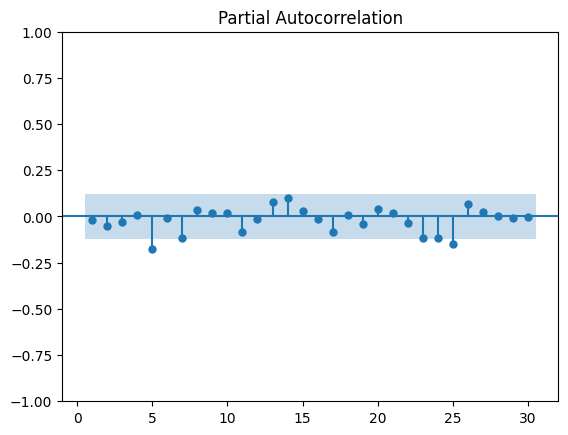

In [120]:
# select the category, sub category, range of lags
df_x = category_selection('Furniture', 'Tables', 30)

`Based on the chart, we need to create lags 5 and 25`

In [139]:
# specify the value of the dataframe to be predicted
lags        = [5, 7, 23, 24, 25]
discount    = 0.5
sales       = 1000
cost        = sales * 0.65
quantity    = 1
# we assume the discount value is still high, so we can predict what if we still give high discounts to customers

In [140]:
# run the model
prediction, X_train, y_train, y_test, y_pred, mod , df_xgb = profit_pred_multiple(lags, 0, sales, cost, quantity, discount)



fold scores: [136.83053158832362, 55.636230128324655, 92.37453607465655, 137.71423302593016, 58.60699470543914]
score across folds 96.233


{'base_score': 0.6, 'colsample_bytree': 0.8466475506209427, 'early_stopping_rounds': 50, 'gamma': 5, 'learning_rate': 0.5777777777777778, 'max_depth': 3, 'n_estimators': 1700, 'reg_alpha': 0.36918807738941456, 'reg_lambda': 0.024514760262626487, 'subsample': 0.7838752327006608}


## Feature Importance

In [141]:
best_est = mod.best_estimator_
feat_impo = best_est.feature_importances_
df_feat_impo = pd.DataFrame(feat_impo).set_index(X_train.columns).sort_values(0)

fig = px.bar(x=df_feat_impo[0], y=df_feat_impo.index, title = 'Feature Importances',
              labels=dict(x="feature value", y="feature name"))
fig.show()

`Based on feature importance, discounts have the strongest influence on profit changes.`

## Compare Prediction and Real Data

In [142]:
# this to show data test and data prediction
comparison = pd.DataFrame(y_test)
comparison = comparison.rename(columns={'Profit': 'Real Profit'})
comparison['Pred Profit'] = y_pred
comparison = comparison.reset_index()

In [143]:
fig = px.line(comparison, x='Order_Date', y=['Real Profit', 'Pred Profit'], title='Real Profit VS Prediction Profit',  
              labels=dict(Order_Date="Date", value="Profit"))
fig.show()

## Collect All Discount Information

In [144]:
def disc():
    pred = pd.DataFrame()
    
    for i in np.linspace(0.1, 1, 10):
        
        # run the model
        prediction, _, _, _, _, _, _ = profit_pred_multiple(lags, 0, sales, cost, quantity, i)
        pred[f'{i:0.1f}'] = prediction['Profit_Prediction']
        
    return pred

In [145]:
pred = disc()



fold scores: [136.83053158832362, 55.636230128324655, 92.37453607465655, 137.71423302593016, 58.60699470543914]
score across folds 96.233


{'base_score': 0.6, 'colsample_bytree': 0.8466475506209427, 'early_stopping_rounds': 50, 'gamma': 5, 'learning_rate': 0.5777777777777778, 'max_depth': 3, 'n_estimators': 1700, 'reg_alpha': 0.36918807738941456, 'reg_lambda': 0.024514760262626487, 'subsample': 0.7838752327006608}




fold scores: [136.83053158832362, 55.636230128324655, 92.37453607465655, 137.71423302593016, 58.60699470543914]
score across folds 96.233


{'base_score': 0.6, 'colsample_bytree': 0.8466475506209427, 'early_stopping_rounds': 50, 'gamma': 5, 'learning_rate': 0.5777777777777778, 'max_depth': 3, 'n_estimators': 1700, 'reg_alpha': 0.36918807738941456, 'reg_lambda': 0.024514760262626487, 'subsample': 0.7838752327006608}




fold scores: [136.83053158832362, 55.636230128324655, 92.37453607465655, 137.71423302593016, 58.60699470543914]
score across folds 96.233


{'base_score': 0.6, 'colsample_bytree': 0.8466475506209427, 'early_stopping_rounds': 50, 'gamma': 5, 'learning_rate': 0.5777777777777778, 'max_depth': 3, 'n_estimators': 1700, 'reg_alpha': 0.36918807738941456, 'reg_lambda': 0.024514760262626487, 'subsample': 0.7838752327006608}




fold scores: [136.83053158832362, 55.636230128324655, 92.37453607465655, 137.71423302593016, 58.60699470543914]
score across folds 96.233


{'base_score': 0.6, 'colsample_bytree': 0.8466475506209427, 'early_stopping_rounds': 50, 'gamma': 5, 'learning_rate': 0.5777777777777778, 'max_depth': 3, 'n_estimators': 1700, 'reg_alpha': 0.36918807738941456, 'reg_lambda': 0.024514760262626487, 'subsample': 0.7838752327006608}




fold scores: [136.83053158832362, 55.636230128324655, 92.37453607465655, 137.71423302593016, 58.60699470543914]
score across folds 96.233


{'base_score': 0.6, 'colsample_bytree': 0.8466475506209427, 'early_stopping_rounds': 50, 'gamma': 5, 'learning_rate': 0.5777777777777778, 'max_depth': 3, 'n_estimators': 1700, 'reg_alpha': 0.36918807738941456, 'reg_lambda': 0.024514760262626487, 'subsample': 0.7838752327006608}




fold scores: [136.83053158832362, 55.636230128324655, 92.37453607465655, 137.71423302593016, 58.60699470543914]
score across folds 96.233


{'base_score': 0.6, 'colsample_bytree': 0.8466475506209427, 'early_stopping_rounds': 50, 'gamma': 5, 'learning_rate': 0.5777777777777778, 'max_depth': 3, 'n_estimators': 1700, 'reg_alpha': 0.36918807738941456, 'reg_lambda': 0.024514760262626487, 'subsample': 0.7838752327006608}




fold scores: [136.83053158832362, 55.636230128324655, 92.37453607465655, 137.71423302593016, 58.60699470543914]
score across folds 96.233


{'base_score': 0.6, 'colsample_bytree': 0.8466475506209427, 'early_stopping_rounds': 50, 'gamma': 5, 'learning_rate': 0.5777777777777778, 'max_depth': 3, 'n_estimators': 1700, 'reg_alpha': 0.36918807738941456, 'reg_lambda': 0.024514760262626487, 'subsample': 0.7838752327006608}




fold scores: [136.83053158832362, 55.636230128324655, 92.37453607465655, 137.71423302593016, 58.60699470543914]
score across folds 96.233


{'base_score': 0.6, 'colsample_bytree': 0.8466475506209427, 'early_stopping_rounds': 50, 'gamma': 5, 'learning_rate': 0.5777777777777778, 'max_depth': 3, 'n_estimators': 1700, 'reg_alpha': 0.36918807738941456, 'reg_lambda': 0.024514760262626487, 'subsample': 0.7838752327006608}




fold scores: [136.83053158832362, 55.636230128324655, 92.37453607465655, 137.71423302593016, 58.60699470543914]
score across folds 96.233


{'base_score': 0.6, 'colsample_bytree': 0.8466475506209427, 'early_stopping_rounds': 50, 'gamma': 5, 'learning_rate': 0.5777777777777778, 'max_depth': 3, 'n_estimators': 1700, 'reg_alpha': 0.36918807738941456, 'reg_lambda': 0.024514760262626487, 'subsample': 0.7838752327006608}




fold scores: [136.83053158832362, 55.636230128324655, 92.37453607465655, 137.71423302593016, 58.60699470543914]
score across folds 96.233


{'base_score': 0.6, 'colsample_bytree': 0.8466475506209427, 'early_stopping_rounds': 50, 'gamma': 5, 'learning_rate': 0.5777777777777778, 'max_depth': 3, 'n_estimators': 1700, 'reg_alpha': 0.36918807738941456, 'reg_lambda': 0.024514760262626487, 'subsample': 0.7838752327006608}


In [146]:
fig = px.line(pred, x=pred.index, y=['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'], title='Profit Prediction per Discount',  
              labels=dict(index="Date", value="Profit"))
fig.show()